This is a simple time-series forecasting project for predicting the sales of a company. First, we look at the total sales across the company, and then we look at sales at the shop level. For this project, we use Facebook Prophet library, Tableau, and statsmodel.

# Exploring the dataset

In [3]:
import pandas as pd
import numpy as np
from prophet import Prophet

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
sales = pd.read_csv("sales_train.csv",  parse_dates = True)
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


# Forecasting Total Monthly Sales Across the Company

We start by taking a look at the total monthly sales across the company.

In [5]:
total_monthly_sales = sales.groupby(["date_block_num"])["item_cnt_day"].sum()

In [6]:
%%html
<div class='tableauPlaceholder' id='viz1678597308961' style='position: relative'><noscript><a href='#'><img alt='Sheet 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;TS&#47;TS_16785972934010&#47;Sheet1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='TS_16785972934010&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;TS&#47;TS_16785972934010&#47;Sheet1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1678597308961');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

from IPython.core.display import display, HTML
display(HTML('<div class='tableauPlaceholder' id='viz1678597308961' style='position: relative'><noscript><a href='#'><img alt='Sheet 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;TS&#47;TS_16785972934010&#47;Sheet1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='TS_16785972934010&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;TS&#47;TS_16785972934010&#47;Sheet1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1678597308961');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>'))

It looks like there are seasonality and trend elements present in the data. We do a naive seasonal decomposition using moving averages. we have to select the type of seasonal component to be either 'additive' or 'multiplicative'. From a quick glance at the above plot, the trens seems to be additive.

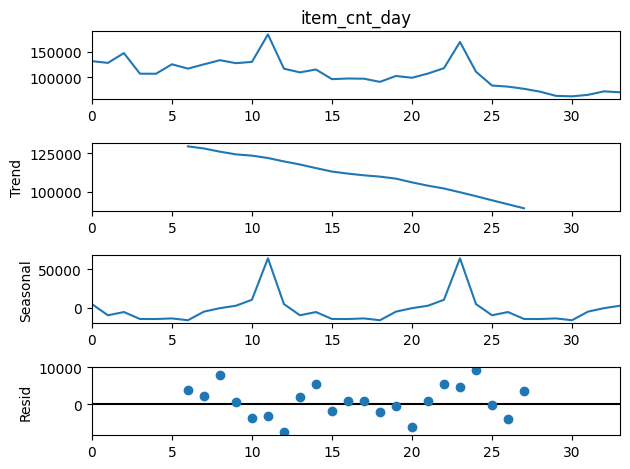

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose (total_monthly_sales, model = 'additive', period = 12)
result.plot();

In [185]:
size = len(total_monthly_sales)
train_size = int(size*0.8)
print(train_size)
train, test = total_monthly_sales[:train_size], total_monthly_sales[train_size:]

27


Text(0.5, 1.0, 'monthly sales across company')

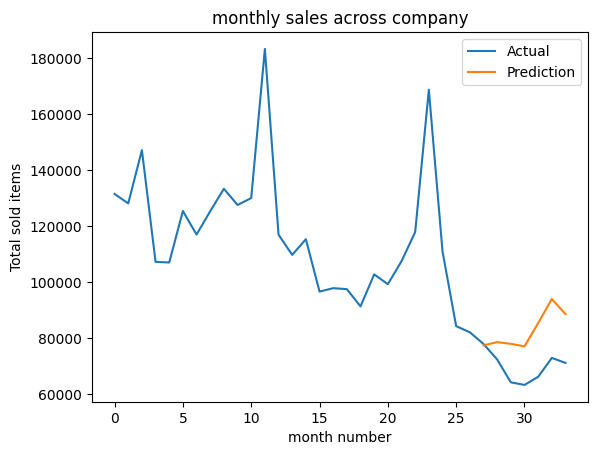

In [194]:
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train, trend = 'add', seasonal = 'add', seasonal_periods =12 ).fit()
test_predictions = fitted_model.forecast(7)

total_monthly_sales.plot(label='Actual')
test_predictions.plot(label='Prediction')
plt.legend()
plt.xlabel("month number")
plt.ylabel("Total sold items")
plt.title("monthly sales across company")

# Forecasting Total Monthly Sales For Each Shop with Prophet

In [43]:
shop_sales = sales[['date_block_num', 'shop_id', 'item_cnt_day']]
shop_monthly_sales = shop_sales.groupby([ 'shop_id', 'date_block_num']).sum()
shop_monthly_sales.index = shop_monthly_sales.index.set_levels( pd.date_range(start ='2013-01-01' , end ='2015-10-01' , freq = 'MS'), level=1 )
shop_monthly_sales = shop_monthly_sales.reset_index()
shop_monthly_sales.columns = ['shop_id','ds','y']
shop_monthly_sales

,shop_id,ds,y
0,0,2013-01-01,5578.0
1,0,2013-02-01,6127.0
2,1,2013-01-01,2947.0
3,1,2013-02-01,3364.0
4,2,2013-01-01,1146.0
...,...,...,...
1581,59,2015-06-01,913.0
1582,59,2015-07-01,992.0
1583,59,2015-08-01,1214.0
1584,59,2015-09-01,914.0


# Filtering and Grouping shops

Prophet requires at least two data points to make a prediction. If we are to perform train and test split by the ratio of 80-20, that means we at least needs 5 data points. Therefore, we drop the shops for which we have less than 5 months of data.

In [159]:
filtered_shops= shop_monthly_sales.groupby('shop_id').filter(lambda g: (len(g) >3) ).reset_index()[['shop_id','ds','y']]
filtered_shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1578 entries, 0 to 1577
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   shop_id  1578 non-null   int64         
 1   ds       1578 non-null   datetime64[ns]
 2   y        1578 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 37.1 KB


In [160]:
group_by_shop = filtered_shops.groupby('shop_id')
group_by_shop.groups.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

# In-Sample Forecasting

The in-sample forecast is the process of formally evaluating the predictive capabilities of the models developed using observed data to see how effective the algorithms are in reproducing data. In in-sample forecasting, the model is fitted on the whole dataset. Below, we forecast the monthly sales for shop number 2. 

In [161]:
def in_sample_forecast(dataset):
    
    model = Prophet()
    
    model.fit(dataset)
    periods = int(0.2*len(dataset))
    future = model.make_future_dataframe(periods=periods,freq='MS')
    forecast = model.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    forecast['shop_id'] = dataset['shop_id'].iloc[0]
        
    return forecast[['ds', 'shop_id', 'yhat', 'yhat_upper', 'yhat_lower']], model

13:06:54 - cmdstanpy - INFO - Chain [1] start processing
13:06:54 - cmdstanpy - INFO - Chain [1] done processing


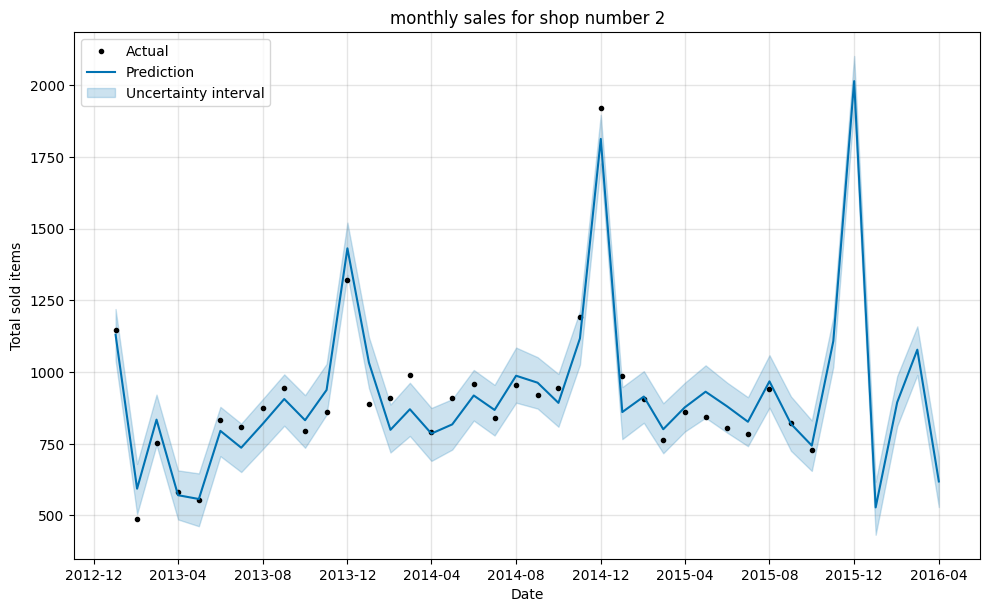

In [162]:
for shop_id in group_by_shop.groups.keys():
    
    group = group_by_shop.get_group(shop_id)  
    group = group.reset_index()
    
    forecast, model= in_sample_forecast(group)

    fig = model.plot(forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']])
    plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
    title = f"monthly sales for shop number { forecast['shop_id'][0] }"
    plt.xlabel("Date")
    plt.ylabel("Total sold items")
    plt.title(title)
    break


# Out-of_Sample Forecasting

out-of-sample forecasts are commonly conducted by splitting a given data set into an in-sample period, used for the initial parameter estimation and model selection, and an out-of-sample period, used to evaluate forecasting performance. 

Note: Prophet.make_future_dataframe gives a suitable dataframe that extends into the future for a specified period of time. By default it will also include the dates from the history, so we will see the model fit as well. we then calculate the rmse error to see how well our model did. 

In [196]:
def out_of_sample_forecast(train, test):
    
    model = Prophet()
    
    model.fit(train)
    future = model.make_future_dataframe(periods=len(test),freq='MS')
    forecast = model.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    forecast['shop_id'] = train['shop_id'].iloc[0]
        
    return forecast[['ds', 'shop_id', 'yhat', 'yhat_upper', 'yhat_lower']]

In [173]:
def train_test_split(group):
    size = len(group)
    train_size = int(size*0.9)
    train, test = group.iloc[:train_size,:], group.iloc[train_size:,:]
    return train, test

In [197]:
results, tests = {}, {}
actual = {}

for shop_id in group_by_shop.groups.keys():
    
    group = group_by_shop.get_group(shop_id)  
    group = group.reset_index()
    train, test = train_test_split(group)
    
    forecast= out_of_sample_forecast(train, test)
    results[shop_id], tests[shop_id] = forecast, test

    se = np.square( forecast.iloc[-len(y_pred):]['yhat'] - test['y'])
    mse = np.mean(se)
    rmse = np.sqrt(mse)

    print(f"shop_id : {shop_id} RMSE:{rmse}")
    break

21:06:18 - cmdstanpy - INFO - Chain [1] start processing
21:06:18 - cmdstanpy - INFO - Chain [1] done processing


shop_id : 2 RMSE:205.32988265697833


Below we visualize the prediction vs. the actual value for shop number 2.

Text(0.5, 1.0, 'monthly sales for shop number 2')

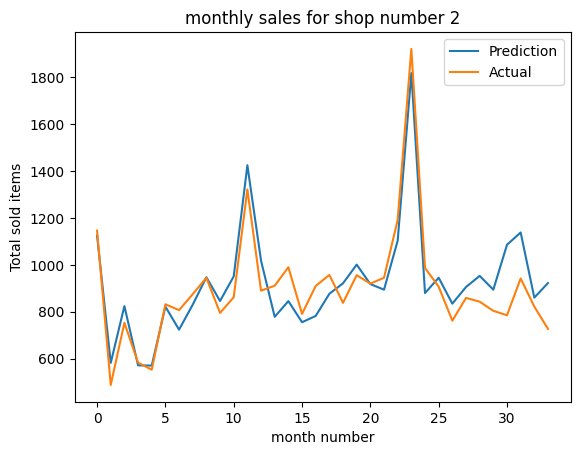

In [195]:
plt.plot( results[2]['yhat'], label='Prediction')
plt.plot(group_by_shop.get_group(2)['y'], label='Actual')
plt.legend()
title = f"monthly sales for shop number { forecast['shop_id'][0] }"
plt.xlabel("month number")
plt.ylabel("Total sold items")
plt.title(title)